## Sampling Strategies

Following Ciresan et al. when constructing a training data set we use all membrane pixels (the minority class) and a subset of the non-membrane pixels (majority class) such that number of examples are balanced 50/50.  This downsampling is re-run each epoch, so that a different subset of non-membrane pixels are introduced each time (there is also some synthetic data augmentation which further diversifies the training).

There are of course different strategies that could be employed when sampling the majority class.  It is reasonable to ask whether some non-membrane examples are more useful than others.  For example, non-membrane examples that are adjacent to membrane pixels are in some sense less important - we don't actually care very much about pixel-level accuracy of the dense estimates (it's unrealistic to expect the "ground truth" to be accurate at this level of fidelity anyway).  Instead, we are more concerned about over- or under-segmentation, which can be caused by introducing or dropping entire membrane segments.

Unfortunately, as of this writing these segmentation desiderata are not directly encoded into our CNN objective function (which currently uses per-pixel accuracy).  However, different sampling strategies might indirectly influence the downstream segmentation errors.  We explore a couple of approaches here.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
import numpy as np
import pylab as plt

# pick up local libraries
sys.path.append(os.path.join('..', 'src'))
sys.path.append(os.path.join('..', 'src', 'thirdparty'))

import emlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
def plot_slice(X, Y=None, cm2=plt.cm.hsv):
    plt.figure(figsize=(15,15))
    plt.imshow(X, cmap=plt.cm.gray, interpolation='none')
    if Y is not None:
        plt.hold(True)
        plt.imshow(Y, cmap=cm2, interpolation='none')
    plt.gca().axes.get_xaxis().set_ticks([])
    plt.gca().axes.get_yaxis().set_ticks([])

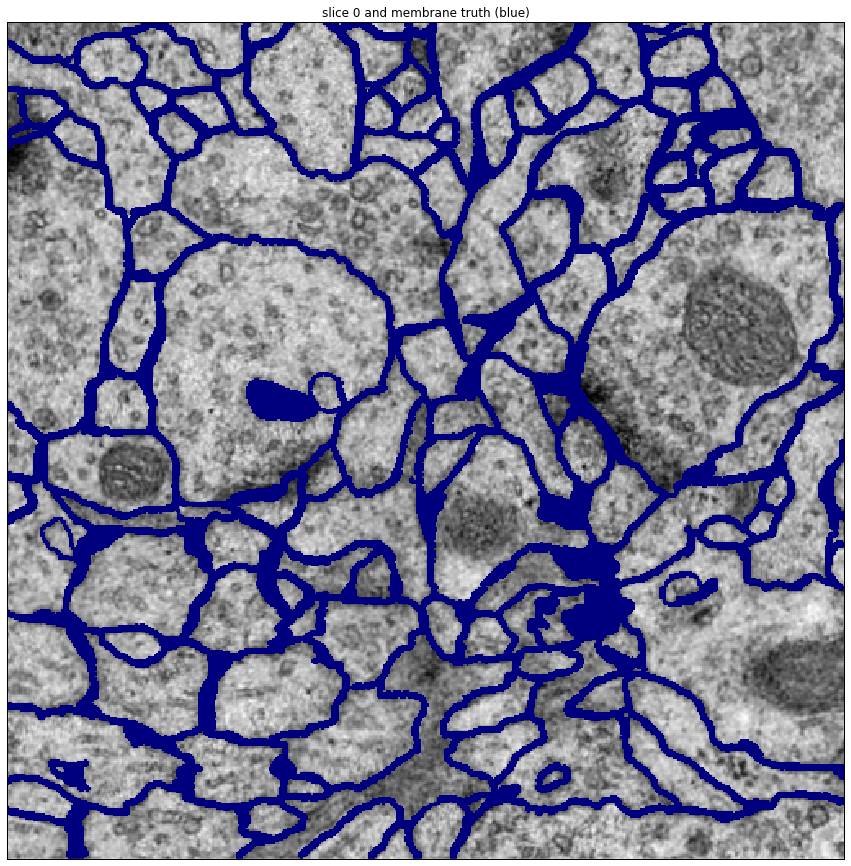

In [130]:
Xtrain = emlib.load_cube('../data/ISBI2012/train-volume.tif')
Ytrain = emlib.load_cube('../data/ISBI2012/train-labels.tif')
Ytrain = Ytrain[:,0,...] # discard channel dimension for truth data

Ycell = np.ma.masked_where(Ytrain!=0, Ytrain)  # membranes are Y=0

plot_slice(Xtrain[0,0,...], Ycell[0,...], cm2=plt.cm.jet)
plt.title('slice 0 and membrane truth (blue)');

## A Few Sampling Approaches

This next bit of code simulates the samples that could be drawn at the beginning of some CNN training epoch.

This code takes a few moments to run, so the anaylsis/visualization is postponed to a subsequent cell.

In [124]:
# APPROACH 1
# This sampling approach takes all membrane pixels and uniformly 
# subsamples the non-membrane (majority) class.
# 
# Presumably this approach will provide a reasonable coverage
# over all non-membrane pixels (implicitly emphasizing larger
# cellular regions)
gen = emlib.stratified_interior_pixel_generator(Ytrain, 0, 100)

Yunif = np.zeros(Ytrain.shape)
for idx, pctComplete in gen:
    Yunif[idx[:,0], idx[:,1], idx[:,2]] = 1
Yunif = np.ma.masked_where(Yunif==0, Yunif)

# APPROACH 2
# For each slice, allocate the non-membrane sampling "budget" equally among all 
# intra-cellular regions.  This has the effect of emphasizing regions where there
# are many smaller cell bodies (at the cost of larger cellular regions).
#
# This sampler also includes a "keep out" region whereby non-membrane examples
# must be at least dilateRadius pixels away from the nearest membrane pixel.
#
gen = emlib.region_sampling_pixel_generator(Ytrain, 0, 100, dilateRadius=2)

Yregion = np.zeros(Ytrain.shape)
for idx, pctComplete in gen:
    Yregion[idx[:,0], idx[:,1], idx[:,2]] = 1
Yregion = np.ma.masked_where(Yregion==0, Yregion)

# APPROACH 3
# TODO: draw "difficult" samples from non-membrane class (i.e. darker colors)


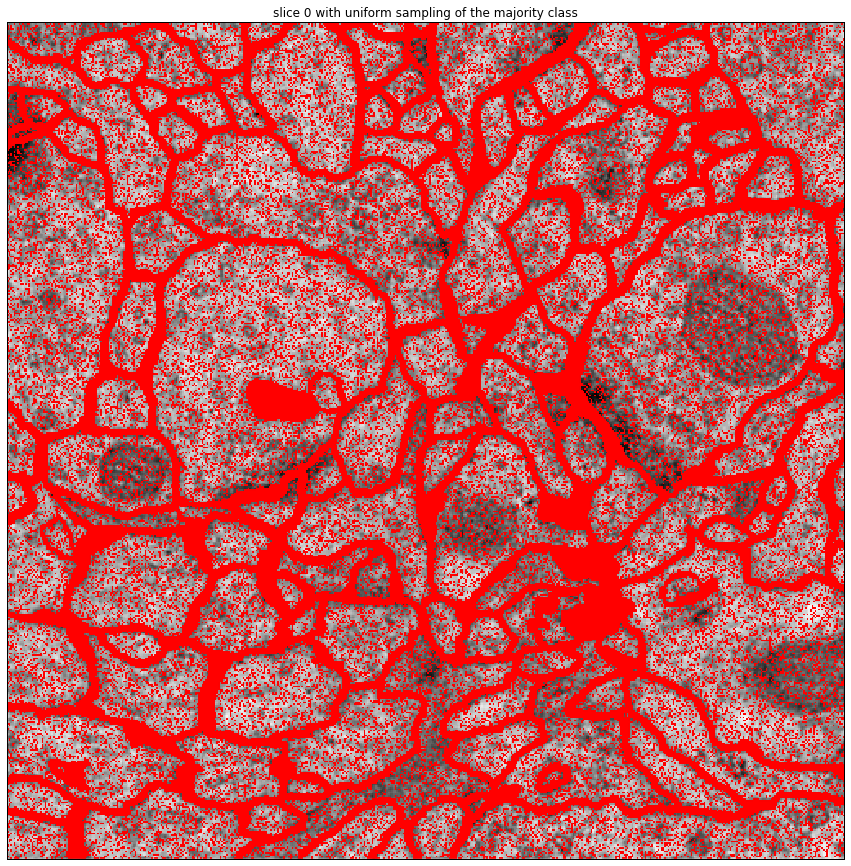

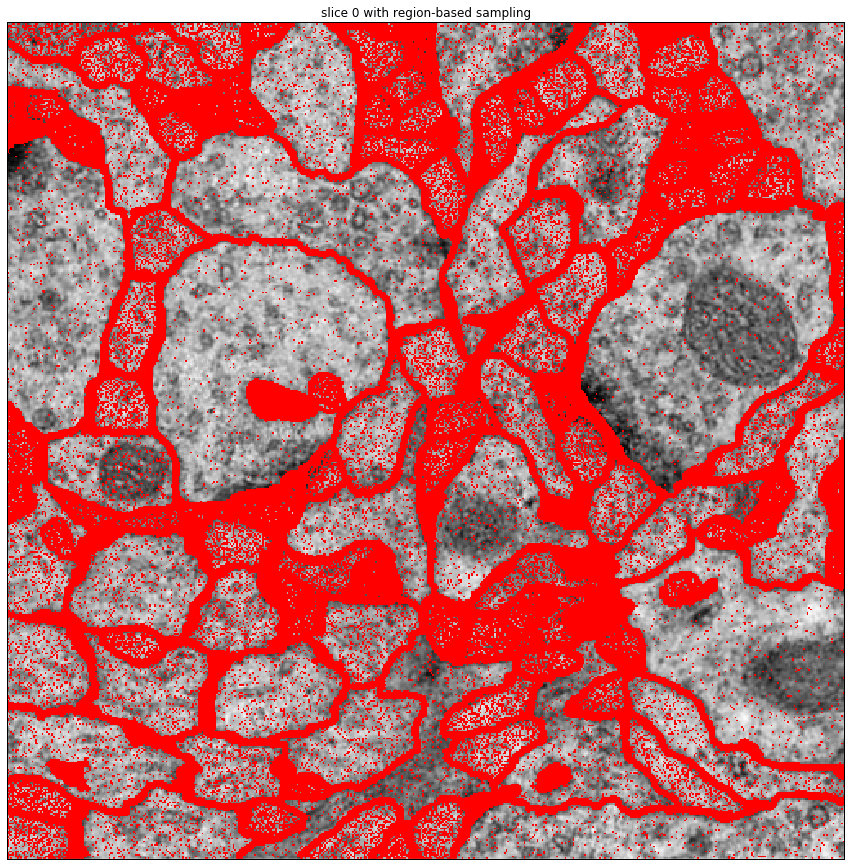

In [132]:
# Pixels selected for use in this training epoch are colored red.
z = 0
plot_slice(Xtrain[z,0,...], Yunif[z,...])
plt.title('slice %d with uniform sampling of the majority class' % z);

plot_slice(Xtrain[z,0,...], Ysamp[z,...])
plt.title('slice %d with region-based sampling' % z);